# Visualizing COVID-19 Data

This notebook is a small collection of examples on visualizing data of the ongoing pandemic of COVID-19. Data is pulled from [this repository](https://github.com/CSSEGISandData/COVID-19) which is updated regularly by the [Whiting School of Engineering of the Johns Hopkins University](https://systems.jhu.edu/research/public-health/ncov/).

## Getting Started
First, you need to get the repository this repository. You can either download it by [clicking here](https://github.com/aquilesC/Covid-19-Jupyter-Notebook/archive/master.zip) or by running the following on your terminal:

```bash
git clone git@github.com:aquilesC/Covid-19-Jupyter-Notebook.git Covid
```

The Data folder is actually another repository, pointing to the John Hopkins repository, therefore, you will need to enter into the ``Covid`` folder and do the following:

```bash
git submodule update --init --recursive
``` 
This will pull the data. Since the repository gets updated twice each day, before running the notebook, you should update the data by running the following, again directly from within the ``Covid`` folder:
```bash
git submodule update --recursive --remote
```

## Importing the modules

In [1]:
import os
import pandas as pd
# plt.style.use('presentation')

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (13,8)
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 16

In [4]:
base_path = 'Data/csse_covid_19_data/csse_covid_19_time_series'
confirmed_file = os.path.join(base_path, 'time_series_19-covid-Confirmed.csv')
deaths_file = os.path.join(base_path, 'time_series_19-covid-Deaths.csv')
recovered_file = os.path.join(base_path, 'time_series_19-covid-Recovered.csv')

In [5]:
def read_data_file(filename):
    data = pd.read_csv(filename)
    data = data.drop(['Province/State', 'Lat', 'Long'], axis=1)
    data = data.groupby(['Country/Region']).sum().transpose()
    data.index = pd.to_datetime(data.index)
    return data

In [6]:
confirmed_data = read_data_file(confirmed_file)
deaths_data = read_data_file(deaths_file)
recovered_data = read_data_file(recovered_file)
recovered_data = read_data_file(recovered_file)
sick_data = confirmed_data - deaths_data - recovered_data

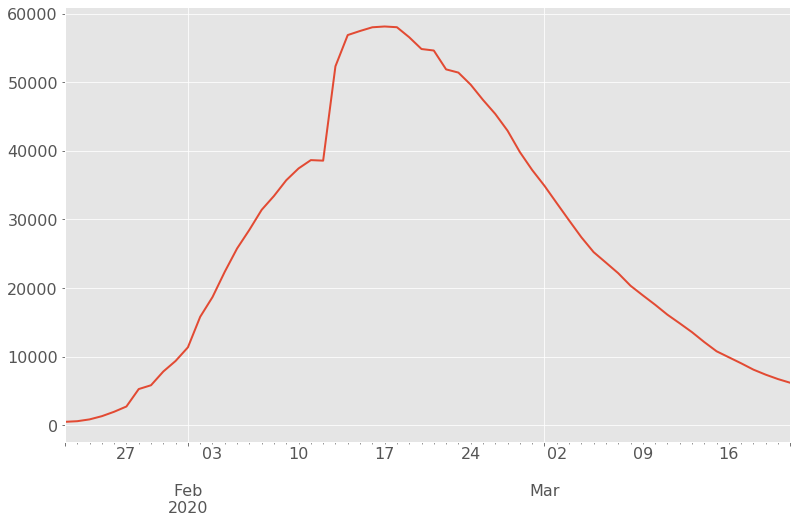

In [7]:
sick_data['China'].plot()

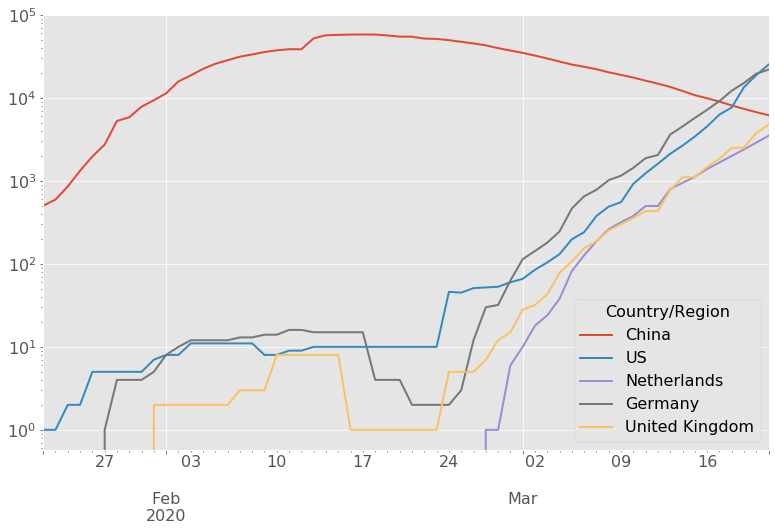

In [9]:
countries = ['China', 'US', 'Netherlands', 'Germany', 'United Kingdom']
ax = sick_data[countries].plot()
ax.set_yscale('log')

(18322, 18343)

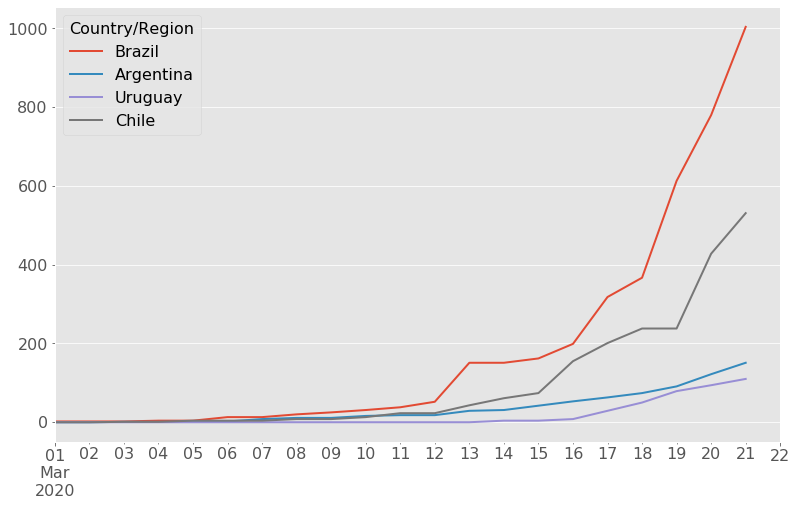

In [12]:
countries = ['Brazil', 'Argentina', 'Uruguay', 'Chile', ]
total = confirmed_data[countries]-recovered_data[countries]-deaths_data[countries]
ax = total.plot()
# ax.set_yscale('log')
ax.set_xlim('2020/03/01', '2020/03/22')

In [115]:
list(confirmed_data)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cruise Ship',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary',
 'Iceland',
 'Ind